<a href="https://colab.research.google.com/github/waldnerf/yieldCNN/blob/main/optimise_so_2D_architectures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Yield forecasting with 2D CNNs
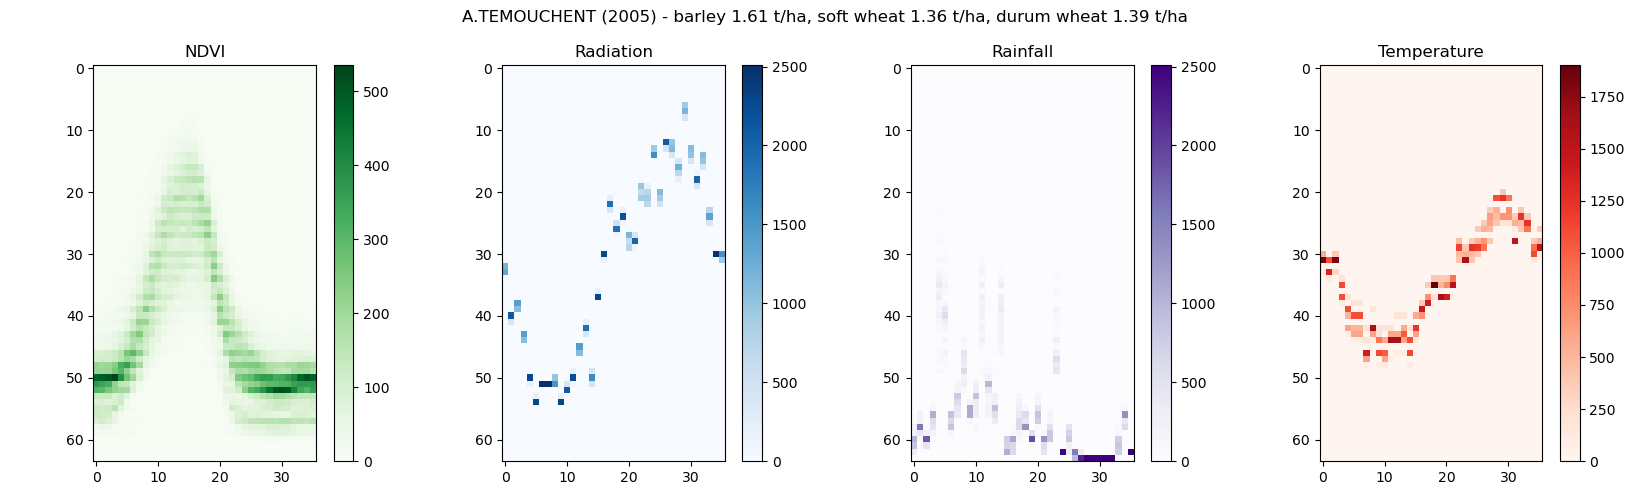

In [ ]:
!pip install optuna
!pip install neptune-client

     |████████████████████████████████| 307kB 12.2MB/s 
     |████████████████████████████████| 81kB 9.1MB/s 
     |████████████████████████████████| 174kB 20.5MB/s 
     |████████████████████████████████| 112kB 15.6MB/s 
     |████████████████████████████████| 51kB 6.5MB/s 
     |████████████████████████████████| 143kB 19.9MB/s 
     |████████████████████████████████| 81kB 9.8MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-cp37-none-any.whl size=11136 sha256=831836a3c240c7d02205a84afa1fe45ec97508c3531291ec600621ca16f5fff9
  Stored in directory: /root/.cache/pip/wheels/25/af/b8/3407109267803f4015e1ee2ff23be0c8c19ce4008665931ee1
Successfully built pyperclip
     |████████████████████████████████| 245kB 13.1MB/s 
     |████████████████████████████████| 829kB 22.5MB/s 
     |████████████████████████████████| 71kB 8.6MB/s 
     |████████████████████████████████| 174kB 32.6MB/s 
     |████████████████████████████████| 133kB 37.1MB/s 
     |████████████████████████████████| 71k

In [ ]:
import os, sys
import argparse
import random
import shutil
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import optuna
import neptune
import joblib
import random

import tensorflow as tf
tf.get_logger().setLevel('ERROR')

import tensorflow.python.util.deprecation as deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

random.seed(4)

In [ ]:
import os, sys
git_dir = '/content/yieldCNN/'
if not os.path.exists(git_dir):
  !git clone https://github.com/waldnerf/yieldCNN
else:
  %cd /content/yieldCNN
  !git pull
  sys.path.insert(0, git_dir)

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

/content/yieldCNN
Already up to date.
Mounted at /content/gdrive


In [ ]:
from yieldCNN.deeplearning.architecture_complexity_2d import *
from yieldCNN.outputfiles.plot import *
from yieldCNN.outputfiles.save import *
from yieldCNN.outputfiles.evaluation import *
from yieldCNN.model_evaluation import *
from yieldCNN.sits.readingsits2D import *
import yieldCNN.mysrc.constants as cst

Running on CoLab
Running on CoLab


## Optimisation function for a CNN with a single input

*   Input 1 is a 2D convolutional neural network


In [ ]:
def objective_CNNw_SISO(trial):
    # 2. Suggest values of the hyperparameters using a trial object.
    nbunits_conv_ = trial.suggest_int('nbunits_conv', 10, 45, step=5)
    kernel_size_ = trial.suggest_int('kernel_size', 2, 5)
    strides_ = trial.suggest_int('strides', 2, 5)
    pool_size_ = trial.suggest_int('pool_size', 1, 5)
    dropout_rate_ = trial.suggest_float('dropout_rate', 0, 0.2, step=0.05)
    nb_fc_ = trial.suggest_categorical('nb_fc', [1, 2])
    funits_fc_ = trial.suggest_categorical('funits_fc', [1, 2, 3])
    activation_ = trial.suggest_categorical('activation', ['relu', 'sigmoid'])

    # Define output filenames
    fn_fig_val = dir_tgt / f'{(out_model).split(".h5")[0]}' \
                           f'_res_{trial.number}_val_{nbunits_conv_}_{kernel_size_}_{strides_}_{pool_size_}_' \
                           f'{round(dropout_rate_ * 100)}_{nb_fc_}_{funits_fc_}_{activation_}.png'
    fn_fig_test = dir_tgt / f"{(out_model).split('.h5')[0]}" \
                            f'_res_{trial.number}_test_{nbunits_conv_}_{kernel_size_}_{strides_}_{pool_size_}_' \
                            f'{round(dropout_rate_ * 100)}_{nb_fc_}_{funits_fc_}_{activation_}.png'
    fn_cv_test = dir_tgt / f'{(out_model).split(".h5")[0]}' \
                           f'_res_{trial.number}_test_{nbunits_conv_}_{kernel_size_}_{strides_}_{pool_size_}_' \
                           f'{round(dropout_rate_ * 100)}_{nb_fc_}_{funits_fc_}_{activation_}.csv'
    out_model_file = dir_tgt / f'{out_model.split(".h5")[0]}_{crop_n}.h5'

    model = Archi_2DCNNw_SISO(Xt,
                              region_ohe,
                              nbunits_conv=nbunits_conv_,
                              kernel_size=kernel_size_,
                              strides=strides_,
                              pool_size=pool_size_,
                              dropout_rate=dropout_rate_,
                              nb_fc=nb_fc_,
                              funits_fc=funits_fc_,
                              activation=activation_,
                              verbose=False)
    mses_val, r2s_val, mses_test, r2s_test = [], [], [], []
    df_val, df_test, df_details = None, None, None
    cv_i = 0
    for test_i in np.unique(groups):
        val_i = random.choice([x for x in np.unique(groups) if x != test_i])
        train_i = [x for x in np.unique(groups) if x != val_i and x != test_i]

        Xt_train, Xv_train, ohe_train, y_train = subset_data(Xt, Xv, region_ohe, y,
                                                             [x in train_i for x in groups])
        Xt_val, Xv_val, ohe_val, y_val = subset_data(Xt, Xv, region_ohe, y, groups == val_i)
        Xt_test, Xv_test, ohe_test, y_test = subset_data(Xt, Xv, region_ohe, y, groups == test_i)

        # ---- Normalizing the data per band
        min_per_t, max_per_t, min_per_v, max_per_v, min_per_y, max_per_y = computingMinMax(Xt_train,
                                                                                           Xv_train,
                                                                                           train_i)
        # Normalise training set
        Xt_train = normalizingData(Xt_train, min_per_t, max_per_t)
        # Normalise validation set
        Xt_val = normalizingData(Xt_val, min_per_t, max_per_t)
        # Normalise test set
        Xt_test = normalizingData(Xt_test, min_per_t, max_per_t)

        # Normalise ys
        transformer_y = MinMaxScaler().fit(y_train[:, [crop_n]])
        ys_train = transformer_y.transform(y_train[:, [crop_n]])
        ys_val = transformer_y.transform(y_val[:, [crop_n]])
        ys_test = transformer_y.transform(y_test[:, [crop_n]])

        # We compile our model with a sampled learning rate.
        model, y_val_preds = cv_Model_MISO(model, Xt_train, ys_train, Xt_val, ys_val,
                                           out_model_file, n_epochs=n_epochs, batch_size=batch_size)
        y_val_preds = transformer_y.inverse_transform(y_val_preds)
        out_val = np.concatenate([y_val[:, [crop_n]], y_val_preds], axis=1)

        y_test_preds = model.predict(x={'ts_input': Xt_test})
        y_test_preds = transformer_y.inverse_transform(y_test_preds)
        out_test = np.concatenate([y_test[:, [crop_n]], y_test_preds], axis=1)
        out_details = np.expand_dims(region_id[groups == test_i].T, axis=1)
        if df_val is None:
            df_val = out_val
            df_test = out_test
            df_details = np.concatenate([out_details, (np.ones_like(out_details) * test_i)], axis=1)
        else:
            df_val = np.concatenate([df_val, out_val], axis=0)
            df_test = np.concatenate([df_test, out_test], axis=0)
            df_details = np.concatenate([df_details,
                                         np.concatenate([out_details, (np.ones_like(out_details) * test_i)], axis=1)],
                                        axis=0)

        mse_val = mean_squared_error(y_val[:, [crop_n]], y_val_preds, squared=False, multioutput='raw_values')
        r2_val = r2_score(y_val[:, [crop_n]], y_val_preds)
        mses_val.append(mse_val)
        r2s_val.append(r2_val)
        mse_test = mean_squared_error(y_test[:, [crop_n]], y_test_preds, squared=False, multioutput='raw_values')
        r2_test = r2_score(y_test[:, [crop_n]], y_test_preds)
        mses_test.append(mse_test)
        r2s_test.append(r2_test)

        trial.report(np.mean(r2s_val), cv_i)  # report mse
        if trial.should_prune():  # let optuna decide whether to prune
            raise optuna.exceptions.TrialPruned()
        cv_i += 1

    av_rmse_val = np.mean(mses_val)
    av_r2_val = np.mean(r2s_val)
    av_rmse_test = np.mean(mses_test)

    plt.plot([0, 5], [0, 5], '-', color='black')
    plt.plot(df_val[:, 1], df_val[:, 0], '.')
    plt.title(f'RMSE: {np.round(av_rmse_val, 4)} - R^2 = {np.round(np.mean(r2s_val), 4)}')

    plt.xlabel('Predictions (t/ha)')
    plt.ylabel('Observations (t/ha)')
    plt.xlim(0.0, 5.0)
    plt.ylim(0.0, 5.0)

    plt.savefig(fn_fig_val)
    plt.close()

    plt.plot([0, 5], [0, 5], '--', color='black')
    plt.plot(df_test[:, 0], df_test[:, 1], '.', color='orange')
    plt.title(f'RMSE: {np.round(av_rmse_test, 4)} - R^2 = {np.round(np.mean(r2s_test), 4)}')

    plt.xlabel('Predictions (t/ha)')
    plt.ylabel('Observations (t/ha)')
    plt.xlim(0.0, 5.0)
    plt.ylim(0.0, 5.0)

    plt.savefig(fn_fig_test)
    plt.close()
    # Save CV results
    df_out = np.concatenate([df_details, df_test], axis=1)
    pd.DataFrame(df_out, columns=['ASAP1_ID', 'Year', 'Observed', 'Predicted']).to_csv(fn_cv_test, index=False)

    return av_r2_val



## Optimisation function for a CNN with two inputs

*   Input 1 is a 2D convolutional neural network
*   Input 2 is a vector of one-hot-encoded features




In [ ]:
def objective_CNNw_MISO(trial):
    # 2. Suggest values of the hyperparameters using a trial object.
    nbunits_conv_ = trial.suggest_int('nbunits_conv', 10, 45, step=5)
    kernel_size_ = trial.suggest_int('kernel_size', 2, 5)
    strides_ = trial.suggest_int('strides', 2, 5)
    pool_size_ = trial.suggest_int('pool_size', 1, 5)
    dropout_rate_ = trial.suggest_float('dropout_rate', 0, 0.2, step=0.05)
    v_fc_ = trial.suggest_categorical('v_fc', [0, 1])
    nbunits_v_ = trial.suggest_int('nbunits_v', 10, 25, step=5)
    nb_fc_ = trial.suggest_categorical('nb_fc', [1, 2])
    funits_fc_ = trial.suggest_categorical('funits_fc', [1, 2, 3])
    activation_ = trial.suggest_categorical('activation', ['relu', 'sigmoid'])

    # Define output filenames
    fn_fig_val = dir_tgt / f'{(out_model).split(".h5")[0]}' \
                           f'_res_{trial.number}_val_{nbunits_conv_}_{kernel_size_}_{strides_}_{pool_size_}_' \
                           f'{round(dropout_rate_ * 100)}_{v_fc_}_{nbunits_v_}_{nb_fc_}_{funits_fc_}_{activation_}.png'
    fn_fig_test = dir_tgt / f"{(out_model).split('.h5')[0]}" \
                            f'_res_{trial.number}_test_{nbunits_conv_}_{kernel_size_}_{strides_}_{pool_size_}_' \
                            f'{round(dropout_rate_ * 100)}_{v_fc_}_{nbunits_v_}_{nb_fc_}_{funits_fc_}_{activation_}.png'
    fn_cv_test = dir_tgt / f'{(out_model).split(".h5")[0]}' \
                           f'_res_{trial.number}_test_{nbunits_conv_}_{kernel_size_}_{strides_}_{pool_size_}_' \
                           f'{round(dropout_rate_ * 100)}_{v_fc_}_{nbunits_v_}_{nb_fc_}_{funits_fc_}_{activation_}.csv'
    out_model_file = dir_tgt / f'{out_model.split(".h5")[0]}_{crop_n}.h5'

    model = Archi_2DCNNw_MISO(Xt,
                              region_ohe,
                              nbunits_conv=nbunits_conv_,
                              kernel_size=kernel_size_,
                              strides=strides_,
                              pool_size=pool_size_,
                              dropout_rate=dropout_rate_,
                              v_fc=v_fc_,
                              nbunits_v=nbunits_v_,
                              nb_fc=nb_fc_,
                              funits_fc=funits_fc_,
                              activation=activation_,
                              verbose=False)
    mses_val, r2s_val, mses_test, r2s_test = [], [], [], []
    df_val, df_test, df_details = None, None, None
    cv_i = 0
    for test_i in np.unique(groups):
        val_i = random.choice([x for x in np.unique(groups) if x != test_i])
        train_i = [x for x in np.unique(groups) if x != val_i and x != test_i]

        Xt_train, Xv_train, ohe_train, y_train = subset_data(Xt, Xv, region_ohe, y,
                                                             [x in train_i for x in groups])
        Xt_val, Xv_val, ohe_val, y_val = subset_data(Xt, Xv, region_ohe, y, groups == val_i)
        Xt_test, Xv_test, ohe_test, y_test = subset_data(Xt, Xv, region_ohe, y, groups == test_i)

        # ---- Normalizing the data per band
        min_per_t, max_per_t, min_per_v, max_per_v, min_per_y, max_per_y = computingMinMax(Xt_train,
                                                                                           Xv_train,
                                                                                           train_i)
        # Normalise training set
        Xt_train = normalizingData(Xt_train, min_per_t, max_per_t)
        Xv_train = normalizingData(Xv_train, min_per_v, max_per_v)
        # Normalise validation set
        Xt_val = normalizingData(Xt_val, min_per_t, max_per_t)
        Xv_val = normalizingData(Xv_val, min_per_v, max_per_v)
        # Normalise test set
        Xt_test = normalizingData(Xt_test, min_per_t, max_per_t)
        Xv_test = normalizingData(Xv_test, min_per_v, max_per_v)

        # Normalise ys
        transformer_y = MinMaxScaler().fit(y_train[:, [crop_n]])
        ys_train = transformer_y.transform(y_train[:, [crop_n]])
        ys_val = transformer_y.transform(y_val[:, [crop_n]])
        ys_test = transformer_y.transform(y_test[:, [crop_n]])

        # ---- concatenate OHE and Xv / Here we discard the proportion of each crop and only keep OHE
        Xv_train = ohe_train  # np.concatenate([Xv_train[:, [crop_n]], ohe_train], axis=1)
        Xv_val = ohe_val  # np.concatenate([Xv_val[:, [crop_n]], ohe_val], axis=1)
        Xv_test = ohe_test  #np.concatenate([Xv_test[:, [crop_n]], ohe_test], axis=1)

        # We compile our model with a sampled learning rate.
        model, y_val_preds = cv_Model_MISO(model, Xt_train, Xv_train, ys_train, Xt_val, Xv_val, ys_val,
                                           out_model_file, n_epochs=n_epochs, batch_size=batch_size)
        y_val_preds = transformer_y.inverse_transform(y_val_preds)
        out_val = np.concatenate([y_val[:, [crop_n]], y_val_preds], axis=1)

        y_test_preds = model.predict(x={'ts_input': Xt_test, 'v_input': Xv_test})
        y_test_preds = transformer_y.inverse_transform(y_test_preds)
        out_test = np.concatenate([y_test[:, [crop_n]], y_test_preds], axis=1)
        out_details = np.expand_dims(region_id[groups == test_i].T, axis=1)
        if df_val is None:
            df_val = out_val
            df_test = out_test
            df_details = np.concatenate([out_details, (np.ones_like(out_details) * test_i)], axis=1)
        else:
            df_val = np.concatenate([df_val, out_val], axis=0)
            df_test = np.concatenate([df_test, out_test], axis=0)
            df_details = np.concatenate([df_details,
                                         np.concatenate([out_details, (np.ones_like(out_details) * test_i)], axis=1)],
                                        axis=0)

        mse_val = mean_squared_error(y_val[:, [crop_n]], y_val_preds, squared=False, multioutput='raw_values')
        r2_val = r2_score(y_val[:, [crop_n]], y_val_preds)
        mses_val.append(mse_val)
        r2s_val.append(r2_val)
        mse_test = mean_squared_error(y_test[:, [crop_n]], y_test_preds, squared=False, multioutput='raw_values')
        r2_test = r2_score(y_test[:, [crop_n]], y_test_preds)
        mses_test.append(mse_test)
        r2s_test.append(r2_test)

        trial.report(np.mean(r2s_val), cv_i)  # report mse
        if trial.should_prune():  # let optuna decide whether to prune
            raise optuna.exceptions.TrialPruned()
        cv_i += 1

    av_rmse_val = np.mean(mses_val)
    av_r2_val = np.mean(r2s_val)
    av_rmse_test = np.mean(mses_test)

    plt.plot([0, 5], [0, 5], '-', color='black')
    plt.plot(df_val[:, 1], df_val[:, 0], '.')
    plt.title(f'RMSE: {np.round(av_rmse_val, 4)} - R^2 = {np.round(np.mean(r2s_val), 4)}')

    plt.xlabel('Predictions (t/ha)')
    plt.ylabel('Observations (t/ha)')
    plt.xlim(0.0, 5.0)
    plt.ylim(0.0, 5.0)

    plt.savefig(fn_fig_val)
    plt.close()

    plt.plot([0, 5], [0, 5], '--', color='black')
    plt.plot(df_test[:, 0], df_test[:, 1], '.', color='orange')
    plt.title(f'RMSE: {np.round(av_rmse_test, 4)} - R^2 = {np.round(np.mean(r2s_test), 4)}')

    plt.xlabel('Predictions (t/ha)')
    plt.ylabel('Observations (t/ha)')
    plt.xlim(0.0, 5.0)
    plt.ylim(0.0, 5.0)

    plt.savefig(fn_fig_test)
    plt.close()
    # Save CV results
    df_out = np.concatenate([df_details, df_test], axis=1)
    pd.DataFrame(df_out, columns=['ASAP1_ID', 'Year', 'Observed', 'Predicted']).to_csv(fn_cv_test, index=False)

    return av_r2_val


## Optimise 2D CNN architecture for all time steps

In [ ]:
import neptune.new as neptune
from getpass import getpass

use_neptune=True
# Logging to your Run
if use_neptune:
  api_token = getpass('Enter your private Neptune API token: ')

Enter your private Neptune API token: ··········


In [ ]:
nept_prjt = 'waldnerf/yieldCNN'# cst.neptune_project

In [ ]:
# ---- Parameters to set
fn_indata = cst.my_project.data_dir / f'{cst.target}_full_2d_dataset.pickle'
dir_out = cst.my_project.params_dir
fn_asapID2AU = cst.root_dir / "raw_data" / "Algeria_REGION_id.csv"
fn_stats90 = cst.root_dir / "raw_data" / "Algeria_stats90.csv"
model_type='2DCNNw_MISO'
overwrite=True
n_epochs = 70
batch_size = 500
n_trials = 100 
n_channels = 4  # -- NDVI, Rad, Rain, Temp

# ---- Get filenames
print("Input file: ", os.path.basename(str(fn_indata)))

# ---- output files
dir_out.mkdir(parents=True, exist_ok=True)
dir_res = dir_out / f'Archi+{str(model_type)}'
dir_res.mkdir(parents=True, exist_ok=True)
print("noarchi: ", model_type)
out_model = f'archi-{model_type}.h5'

# ---- Downloading
Xt_full, Xv, region_id, groups, y = data_reader(fn_indata)

# ---- Convert region to one hot
region_ohe = add_one_hot(region_id)

# loop through all crops
for crop_n in range(y.shape[1]):
    dir_crop = dir_res / f'crop_{crop_n}'
    dir_crop.mkdir(parents=True, exist_ok=True)
    # loop by month
    for month in range(2, 9):
        dir_tgt = dir_crop / f'month_{month}'
        dir_tgt.mkdir(parents=True, exist_ok=True)

        if (len([x for x in dir_tgt.glob('best_model')]) != 0) & (overwrite is False):
            pass
        else:
            rm_tree(dir_tgt)
            idx = month * 3
            Xt = Xt_full[:, :, 0:idx, :]

            study = optuna.create_study(direction='maximize',
                                        pruner=optuna.pruners.SuccessiveHalvingPruner(min_resource=8)
                                        )
            if model_type == '2DCNNw_SISO':
                study.optimize(objective_CNNw_SISO, n_trials=n_trials)
            if model_type == '2DCNNw_MISO':
                study.optimize(objective_CNNw_MISO, n_trials=n_trials)

            trial = study.best_trial
            print('------------------------------------------------')
            print('--------------- Optimisation results -----------')
            print('------------------------------------------------')
            print("Number of finished trials: ", len(study.trials))
            print(f"\n           Best trial ({trial.number})        \n")
            print("R2: ", trial.value)
            print("Params: ")
            for key, value in trial.params.items():
                print("{}: {}".format(key, value))

            joblib.dump(study, os.path.join(dir_tgt, f'study_{crop_n}_{model_type}.dump'))
            # dumped_study = joblib.load(os.path.join(cst.my_project.meta_dir, 'study_in_memory_storage.dump'))
            # dumped_study.trials_dataframe()
            df = study.trials_dataframe().to_csv(os.path.join(dir_tgt, f'study_{crop_n}_{model_type}.csv'))
            # fig = optuna.visualization.plot_slice(study)
            print('------------------------------------------------')
            save_best_model(dir_tgt, f'res_{trial.number}') 
            
            # Logging to your Run
            if use_neptune:
              run = neptune.init(project=nept_prjt,
                                 api_token=api_token) # your credentials

              run["crop"] = crop_n
              run['params'] = trial.params
              run["month"].log(month)
              run['val_r2'].log(trial.value)

              # Evaluate best model on test set
              fn_csv_best = [x for x in (dir_tgt / 'best_model').glob('*.csv')][0]
              res_i = model_evaluation(fn_csv_best, crop_n, month, model_type, fn_asapID2AU, fn_stats90)
              run['R2_p'].log(res_i.R2_p.to_numpy()[0])
              run['MAE_p'].log(res_i.MAE_p.to_numpy()[0])
              run['rMAE_p'].log(res_i.rMAE_p.to_numpy()[0])
              run['ME_p'].log(res_i.ME_p.to_numpy()[0])
              run['RMSE_p'].log(res_i.RMSE_p.to_numpy()[0])
              run['rRMSE_p'].log(res_i.rRMSE_p.to_numpy()[0])
              run['Country_R2_p'].log(res_i.Country_R2_p.to_numpy()[0])
              run['Country_MAE_p'].log(res_i.Country_MAE_p.to_numpy()[0])
              run['Country_ME_p'].log(res_i.Country_ME_p.to_numpy()[0])
              run['Country_RMSE_p'].log(res_i.Country_RMSE_p.to_numpy()[0])
              run['Country_rRMSE_p'].log(res_i.Country_rRMSE_p.to_numpy()[0])
              run['Country_FQ_rRMSE_p'].log(res_i.Country_FQ_rRMSE_p.to_numpy()[0])
              run['Country_FQ_RMSE_p'].log(res_i.Country_FQ_RMSE_p.to_numpy()[0])

              run.stop()

  

[I 2021-07-05 12:04:28,767] A new study created in memory with name: no-name-714606eb-cffd-4b43-a1b6-4f795cd8d476


Input file:  Algeria_full_2d_dataset.pickle
noarchi:  2DCNNw_MISO
